In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_squared_error

from data.city.load_cities import CITY
from data.prediction.methods.mean_predictor import PredictByMean
from data.prediction.methods.XGBoost import PredictByXGBoost

In [3]:
TRAIN_SIZE = 0.7
method = PredictByMean(city=CITY,prediction_length=24*7,train_size=TRAIN_SIZE)
method.train()

station = method.df_dataset.columns[0]
r = method.df_dataset[station].iloc[:168]
method.predict(station, r)

# On calcule la MSE totale pour toutes les stations

mse_values = []
for station in method.df_dataset.columns:
    r = method.df_dataset[station].iloc[:168]
    prediction = method.predict(station, r)
    mse = mean_squared_error(r, prediction)
    mse_values.append(mse)
    
print(f"MSE: {np.mean(mse_values)}")

MSE: 0.062065967586756206


In [4]:
model = PredictByMean(city=CITY,prediction_length=24*7,train_size=TRAIN_SIZE)
model.train()

start_week = 168 * 3
station = 1

df_predict: pd.DataFrame = model.predict(data=CITY.df_hours.columns[station]).reset_index(drop=True)
df_predict[CITY.df_hours.columns[station] + '-obs'] = CITY.df_hours[CITY.df_hours.columns[station]].iloc[start_week:start_week + len(df_predict)].reset_index(drop=True)
df_predict.index = CITY.df_hours['date'].iloc[start_week:start_week + len(df_predict)]

print('MSE:', mean_squared_error(df_predict[df_predict.columns[1]], df_predict[df_predict.columns[0]]))

fig = px.line(
    data_frame=df_predict
)

fig.update_layout(hovermode='x')

fig.show()

TypeError: PredictByMean.predict() missing 1 required positional argument: 'selected_stations'

In [5]:
TRAIN_SIZE = 0.7
PREDICTION_LENGTH = 24*7  # Prédiction sur une semaine
method = PredictByXGBoost(city=CITY, prediction_length=PREDICTION_LENGTH, train_size=TRAIN_SIZE)
method.train()

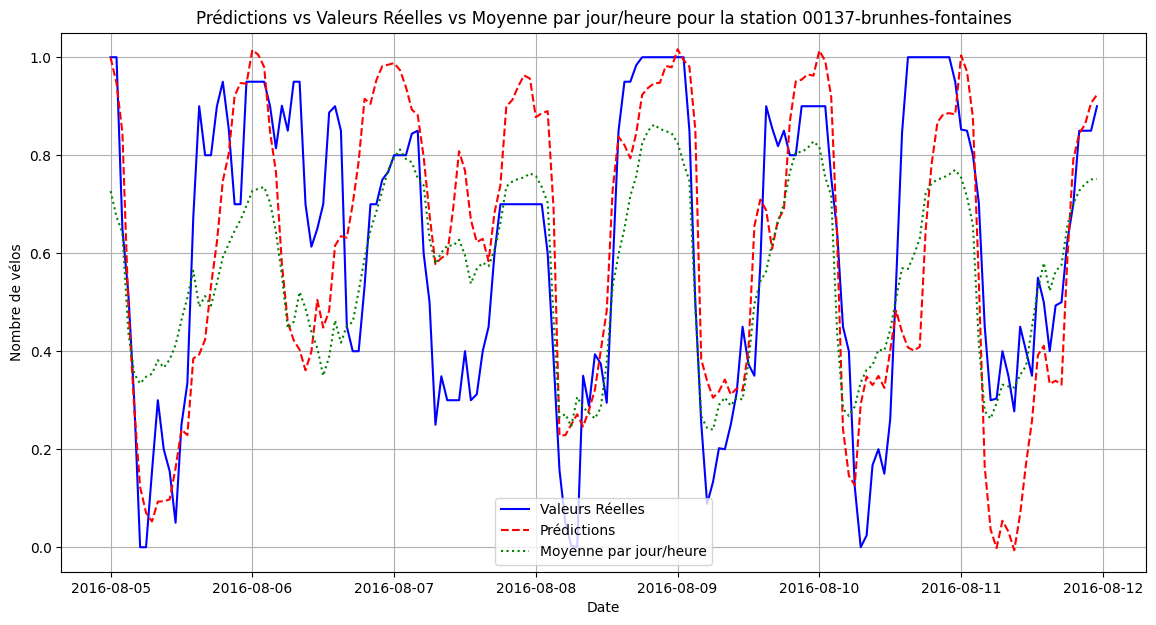

MSE pour les prédictions sur la station 00137-brunhes-fontaines: 0.050567530250066224


In [6]:
station = method.df_dataset.columns[78]  # Changer la station ici
last_train_date = method.train_dataset.index[-1]  

start_prediction = last_train_date + pd.DateOffset(hours=1)  
end_prediction = start_prediction + pd.DateOffset(hours=PREDICTION_LENGTH - 1)  
real_data = method.df_dataset.loc[start_prediction:end_prediction, station]

predictions = method.predict(station)

df_mean = method.df_dataset.copy()
df_mean = df_mean.loc[:last_train_date]
df_mean['hour'] = df_mean.index.hour
df_mean['day_of_week'] = df_mean.index.dayofweek
hourly_weekday_mean = df_mean.groupby(['day_of_week', 'hour'])[station].mean().unstack()

def get_hourly_weekday_means(start, end):
    index = pd.date_range(start=start, end=end, freq='H')
    mean_values = [hourly_weekday_mean.loc[date.dayofweek, date.hour] for date in index]
    return pd.Series(data=mean_values, index=index)

predicted_means = get_hourly_weekday_means(start_prediction, end_prediction)

plt.figure(figsize=(14, 7))
plt.plot(real_data.index, real_data.values, label='Valeurs Réelles', color='blue')
plt.plot(predictions.index, predictions.values, label='Prédictions', color='red', linestyle='--')
plt.plot(predicted_means.index, predicted_means.values, label='Moyenne par jour/heure', color='green', linestyle=':')
plt.title(f'Prédictions vs Valeurs Réelles vs Moyenne par jour/heure pour la station {station}')
plt.xlabel('Date')
plt.ylabel('Nombre de vélos')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.show()


# Calculer la Mean Squared Error
mse = mean_squared_error(real_data.values, predictions.values)
print(f'MSE pour les prédictions sur la station {station}: {mse}')


In [7]:
# On calcule la MSE totale pour toutes les stations
mse_values = []

for station in method.df_dataset.columns:
    real_data = method.df_dataset.loc[start_prediction:end_prediction, station]
    predictions = method.predict(station)

    mse = mean_squared_error(real_data.values, predictions.values)
    mse_values.append(mse)
    
total_mse = np.mean(mse_values)
print(f'MSE totale pour les prédictions sur toutes les stations: {total_mse}')

MSE totale pour les prédictions sur toutes les stations: 0.08207239141344218


In [8]:
DATE_RANGE = ('04-01-2016', '10-31-2016')

df = pd.read_csv(
    f'./data/city/Toulouse/X_hour_toulouse.csv',
    index_col=0
)
df['date'] = pd.date_range(*DATE_RANGE, freq='1h')[:len(df)]
df.set_index('date', inplace=True)

In [9]:
a = pd.Series([False, True, True, False, True], index=[0, 1, 2, 9, 10])
a[0]

False

In [10]:
def get_interpolated_indices(serie: pd.Series, tolerance: float=1e-3, output_type: str='mask'):

    mask, current_mask = [], []
    for index in range(len(serie)):
        # Si < 2 éléments d'affilé de suite
        if len(current_mask) < 2:
            current_mask.append(serie.index.values[index])
            continue
        
        # On check si la différence est la même entre trois éléments d'affilé de suite
        if np.abs((serie.values[index - 2] - serie.values[index - 1]) - (serie.values[index - 1] - serie.values[index])) < tolerance:
            current_mask.append(serie.index.values[index])
            continue
        
        # Si la différence est constante et la longueur de l'interpolation < 24 heures
        if len(current_mask) < 24 and np.abs(serie.values[index - 2] - serie.values[index - 1]) < tolerance:
            current_mask = []

        if len(current_mask) > 2:
            mask.append(current_mask[1:-1])
        current_mask = [serie.index.values[index - 1], serie.index.values[index]]

    if output_type == 'mask':
        return serie[[index_mask for row in mask for index_mask in row]].index

    if output_type == 'list':
        return mask
    
    raise ValueError('The "output_type" value must be one of the following : "mask", "list".')

In [11]:
index_column = 0
tmp = df.loc[:].iloc[:, index_column].copy()
# tmp = pd.Series([-2, 1, 2, 3, 84, 56, 98, 5, 4, 3, 2, 92])

index = get_interpolated_indices(tmp, output_type='list')
print(len(index))
index = [u for v in index for u in v]
tmp.loc[index] = np.nan

a = tmp.to_frame()
a['origine'] = df.iloc[:, index_column].copy()
fig = px.line(a).show()

51


## Mathilde (si c'est faux, pardon)

Forêt aléatoire

In [22]:
from sklearn.ensemble import RandomForestRegressor

TRAIN_SIZE = 0.7
PREDICTION_LENGTH = 24*7  # Prédiction sur une semaine

model = RandomForestRegressor(n_estimators=100, random_state=0)
X_train = method.train_dataset.drop(station, axis=1)
y_train = method.train_dataset[station]
X_test = method.df_dataset.drop(station, axis=1).loc[start_prediction:end_prediction]
y_test = method.df_dataset[station].loc[start_prediction:end_prediction]
common_columns = X_train.columns.intersection(X_test.columns)
X_test = X_test[common_columns]

model.fit(X_train, y_train)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test.values, predictions)
print(f'MSE pour les prédictions sur la station {station}: {mse}')


MSE pour les prédictions sur la station 00007-place-victor-hugo: 0.03847970985802906


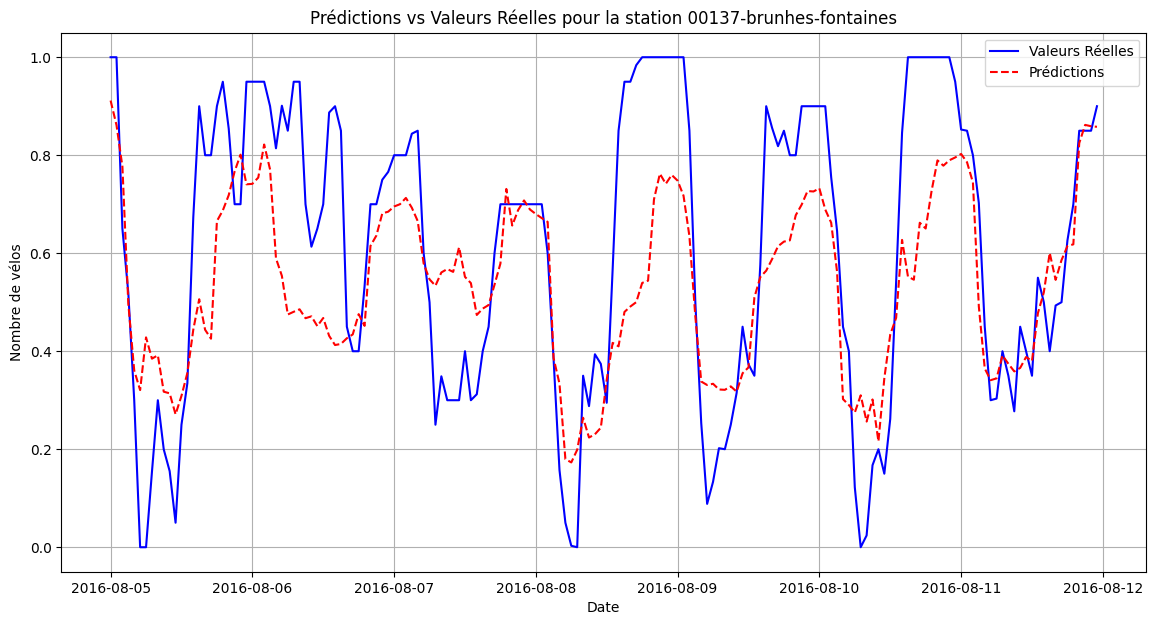

In [21]:
from sklearn.ensemble import RandomForestRegressor

new_station = method.df_dataset.columns[78]  # Changer la station ici
last_train_date = method.train_dataset.index[-1]

start_prediction = last_train_date + pd.DateOffset(hours=1)
end_prediction = start_prediction + pd.DateOffset(hours=PREDICTION_LENGTH - 1)

real_data = method.df_dataset.loc[start_prediction:end_prediction, new_station]
model = RandomForestRegressor(n_estimators=100, random_state=0)
X_train = method.train_dataset.drop(new_station, axis=1)
y_train = method.train_dataset[new_station]
X_test = method.df_dataset.drop(new_station, axis=1).loc[start_prediction:end_prediction]
y_test = method.df_dataset[new_station].loc[start_prediction:end_prediction]

common_columns = X_train.columns.intersection(X_test.columns)
X_test = X_test[common_columns]

model.fit(X_train, y_train)
predictions = model.predict(X_test)

plt.figure(figsize=(14, 7))
plt.plot(real_data.index, real_data.values, label='Valeurs Réelles', color='blue')
plt.plot(X_test.index, predictions, label='Prédictions', color='red', linestyle='--')
plt.title(f'Prédictions vs Valeurs Réelles pour la station {new_station}')
plt.xlabel('Date')
plt.ylabel('Nombre de vélos')
plt.legend()
plt.grid(True)
plt.show()


Réseau de neurones

In [24]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

TRAIN_SIZE = 0.7
PREDICTION_LENGTH = 24*7  # Prédiction sur une semaine

model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=0)
X_train = method.train_dataset.drop(station, axis=1)
y_train = method.train_dataset[station]
X_test = method.df_dataset.drop(station, axis=1).loc[start_prediction:end_prediction]
y_test = method.df_dataset[station].loc[start_prediction:end_prediction]
common_columns = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_columns]
X_test = X_test[common_columns]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)

mse = mean_squared_error(y_test.values, predictions)
print(f'MSE pour les prédictions sur la station {station}: {mse}')

MSE pour les prédictions sur la station 00007-place-victor-hugo: 0.11265114811820684


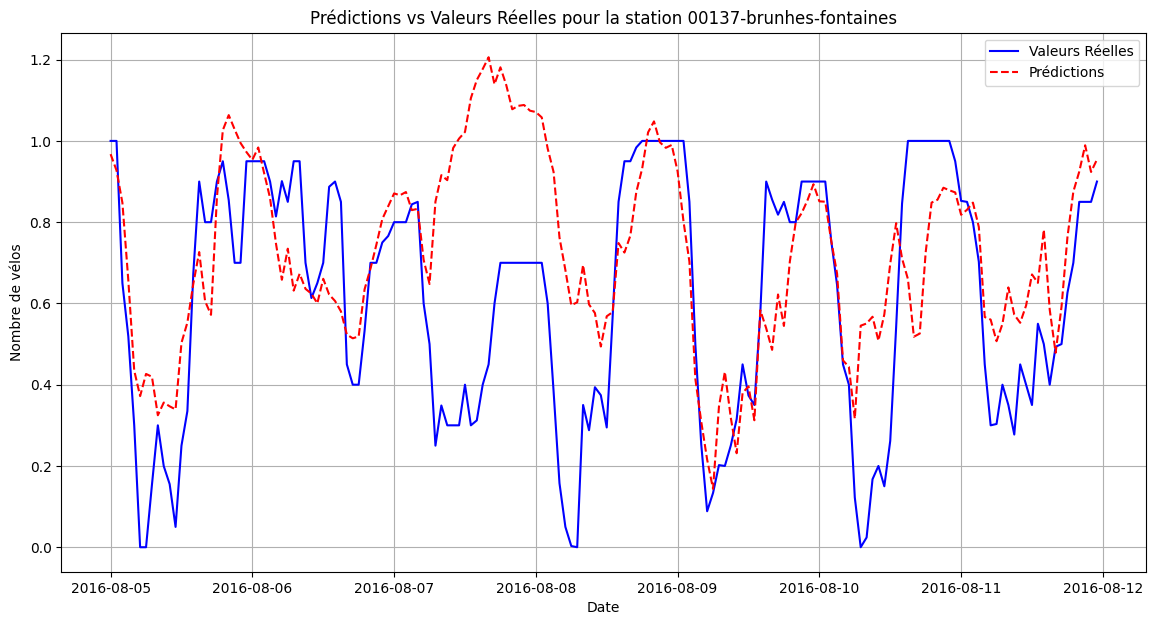

In [27]:
new_station = method.df_dataset.columns[78]  # Changer la station ici
last_train_date = method.train_dataset.index[-1]

start_prediction = last_train_date + pd.DateOffset(hours=1)
end_prediction = start_prediction + pd.DateOffset(hours=PREDICTION_LENGTH - 1)

real_data = method.df_dataset.loc[start_prediction:end_prediction, new_station]
model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=0)
X_train = method.train_dataset.drop(new_station, axis=1)
y_train = method.train_dataset[new_station]
X_test = method.df_dataset.drop(new_station, axis=1).loc[start_prediction:end_prediction]
y_test = method.df_dataset[new_station].loc[start_prediction:end_prediction]

common_columns = X_train.columns.intersection(X_test.columns)
X_test = X_test[common_columns]

model.fit(X_train, y_train)
predictions = model.predict(X_test)

plt.figure(figsize=(14, 7))
plt.plot(real_data.index, real_data.values, label='Valeurs Réelles', color='blue')
plt.plot(X_test.index, predictions, label='Prédictions', color='red', linestyle='--')
plt.title(f'Prédictions vs Valeurs Réelles pour la station {new_station}')
plt.xlabel('Date')
plt.ylabel('Nombre de vélos')
plt.legend()
plt.grid(True)
plt.show()


Régression linéaire multiple

In [28]:
from sklearn.linear_model import LinearRegression

TRAIN_SIZE = 0.7
PREDICTION_LENGTH = 24 * 7  # Prédiction sur une semaine

model = LinearRegression()
X_train = method.train_dataset.drop(station, axis=1)
y_train = method.train_dataset[station]
X_test = method.df_dataset.drop(station, axis=1).loc[start_prediction:end_prediction]
y_test = method.df_dataset[station].loc[start_prediction:end_prediction]

common_columns = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_columns]
X_test = X_test[common_columns]

model.fit(X_train, y_train)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test.values, predictions)
print(f'MSE pour les prédictions sur la station {station}: {mse}')


MSE pour les prédictions sur la station 00007-place-victor-hugo: 0.06899862634108321


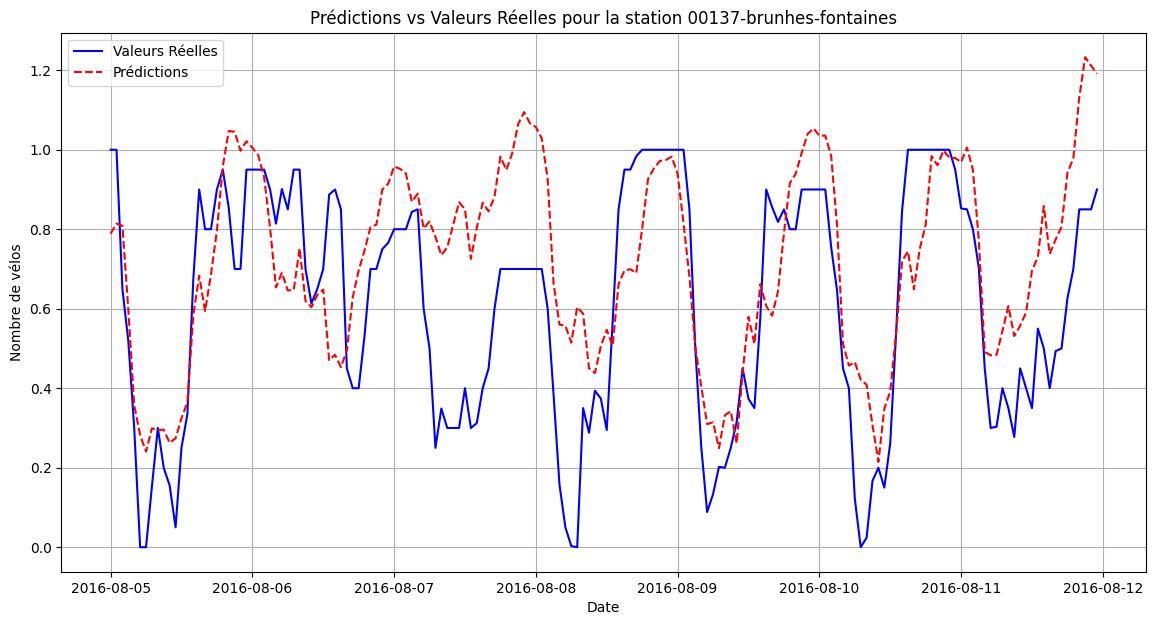

In [29]:
new_station = method.df_dataset.columns[78]  # Changer la station ici
last_train_date = method.train_dataset.index[-1]

start_prediction = last_train_date + pd.DateOffset(hours=1)
end_prediction = start_prediction + pd.DateOffset(hours=PREDICTION_LENGTH - 1)

real_data = method.df_dataset.loc[start_prediction:end_prediction, new_station]
model = LinearRegression()
X_train = method.train_dataset.drop(new_station, axis=1)
y_train = method.train_dataset[new_station]
X_test = method.df_dataset.drop(new_station, axis=1).loc[start_prediction:end_prediction]
y_test = method.df_dataset[new_station].loc[start_prediction:end_prediction]

common_columns = X_train.columns.intersection(X_test.columns)
X_test = X_test[common_columns]

model.fit(X_train, y_train)
predictions = model.predict(X_test)

plt.figure(figsize=(14, 7))
plt.plot(real_data.index, real_data.values, label='Valeurs Réelles', color='blue')
plt.plot(X_test.index, predictions, label='Prédictions', color='red', linestyle='--')
plt.title(f'Prédictions vs Valeurs Réelles pour la station {new_station}')
plt.xlabel('Date')
plt.ylabel('Nombre de vélos')
plt.legend()
plt.grid(True)
plt.show()

Apprentissage profond supervisé

In [30]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

TRAIN_SIZE = 0.7
PREDICTION_LENGTH = 24 * 7  # Prédiction sur une semaine

model = keras.Sequential([
    keras.layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)
predictions = model.predict(X_test_scaled)

mse = mean_squared_error(y_test.values, predictions)
print(f'MSE pour les prédictions sur la station {station}: {mse}')


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step - loss: 0.1970
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.0248
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 0.0129
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 0.0085
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 0.0062
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.0051
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 0.0040
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 0.0037
Epoch 9/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 0.0032
Epoch 10/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 0.0024
Epoch 11/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 0.0022
Epoch 12/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.0022
Epoch 13/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 0.0025
Epoch 14/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 0.0020
Epoch 15/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 0.0025


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 590us/step - loss: 0.3886
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.0344
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 0.0161
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 0.0099
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 0.0077
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 0.0051
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.0045
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.0036
Epoch 9/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 0.0033
Epoch 10/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 0.0029
Epoch 11/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.0023
Epoch 12/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.0023
Epoch 13/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.0020
Epoch 14/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 0.0018  
Epoch 15/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 0.001

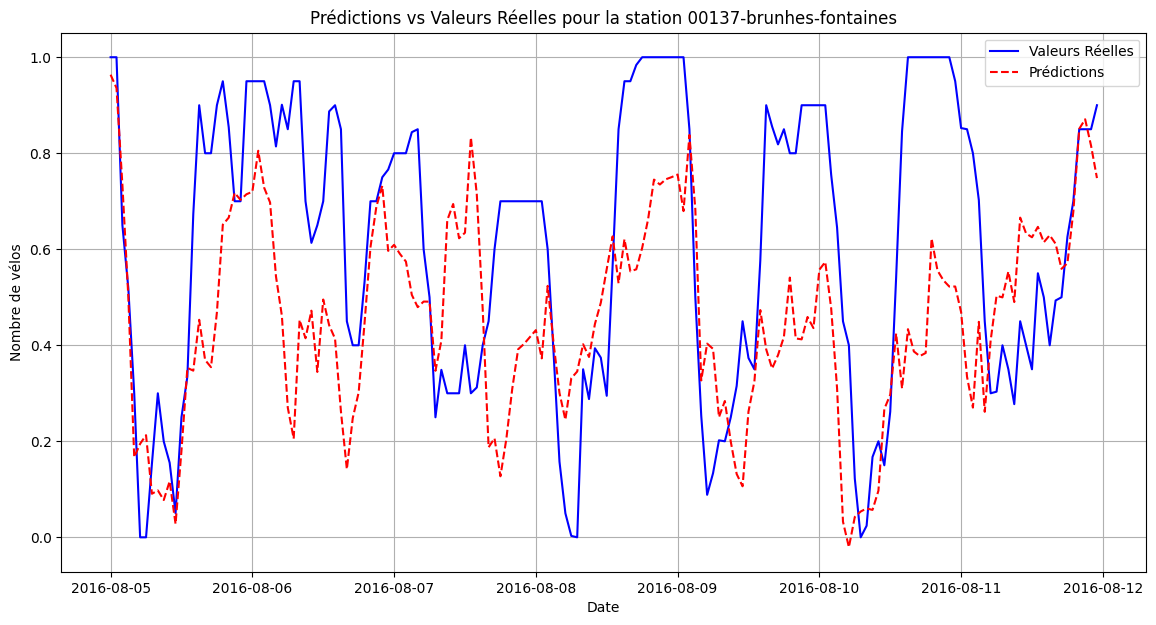

In [32]:
new_station = method.df_dataset.columns[78]  # Changer la station ici
last_train_date = method.train_dataset.index[-1]

start_prediction = last_train_date + pd.DateOffset(hours=1)
end_prediction = start_prediction + pd.DateOffset(hours=PREDICTION_LENGTH - 1)

real_data = method.df_dataset.loc[start_prediction:end_prediction, new_station]

model = keras.Sequential([
    keras.layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
X_train = method.train_dataset.drop(new_station, axis=1)
y_train = method.train_dataset[new_station]
X_test = method.df_dataset.drop(new_station, axis=1).loc[start_prediction:end_prediction]
y_test = method.df_dataset[new_station].loc[start_prediction:end_prediction]
common_columns = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_columns]
X_test = X_test[common_columns]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)
predictions = model.predict(X_test_scaled)

plt.figure(figsize=(14, 7))
plt.plot(real_data.index, real_data.values, label='Valeurs Réelles', color='blue')
plt.plot(X_test.index, predictions, label='Prédictions', color='red', linestyle='--')
plt.title(f'Prédictions vs Valeurs Réelles pour la station {new_station}')
plt.xlabel('Date')
plt.ylabel('Nombre de vélos')
plt.legend()
plt.grid(True)
plt.show()

SARIMA (Seasonal Autoregressive Integrated Moving Average) : Une méthode classique de modélisation des séries temporelles prenant en compte la saisonnalité, les tendances et les composantes autoregressives.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.16926D-01    |proj g|=  3.55254D+00

At iterate    5    f= -6.56112D-01    |proj g|=  3.14551D+00

At iterate   10    f= -6.99961D-01    |proj g|=  6.73289D-01

At iterate   15    f= -7.13082D-01    |proj g|=  3.31294D-01

At iterate   20    f= -7.51419D-01    |proj g|=  1.59386D-01

At iterate   25    f= -7.57847D-01    |proj g|=  4.00684D-02

At iterate   30    f= -7.57889D-01    |proj g|=  1.50002D-03

At iterate   35    f= -7.57948D-01    |proj g|=  2.73260D-02

At iterate   40    f= -7.59756D-01    |proj g|=  1.32698D-01

At iterate   45    f= -7.74629D-01    |proj g|=  2.31376D-02


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -7.80687D-01    |proj g|=  1.17386D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   1.174D-01  -7.807D-01
  F = -0.78068700647754430     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


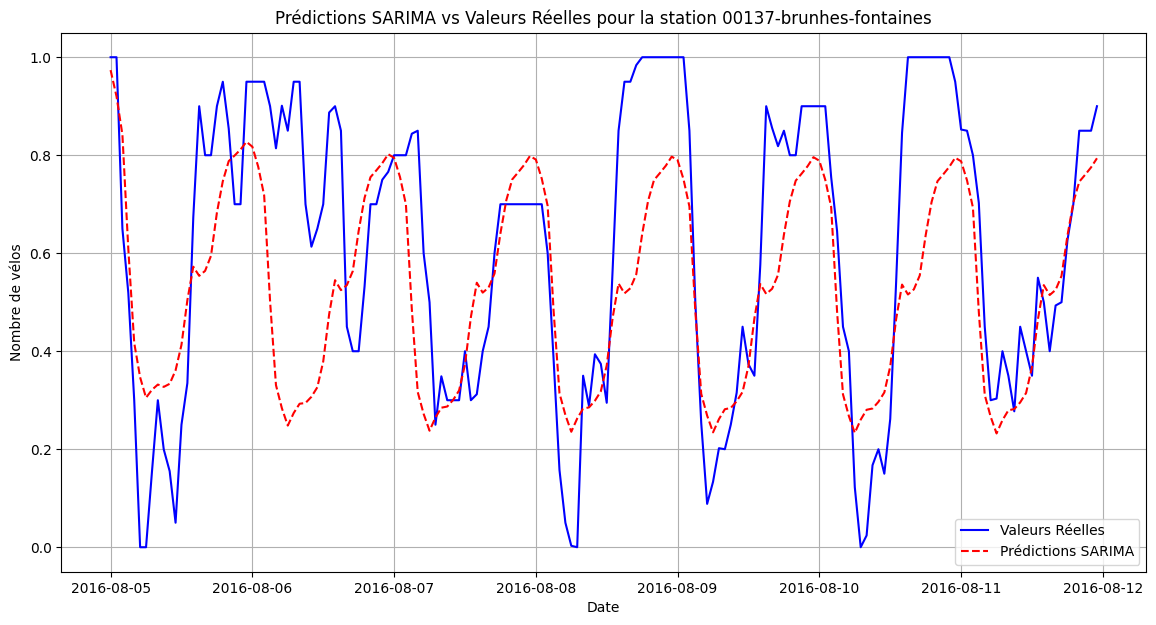

MSE pour les prédictions SARIMA sur la station 00137-brunhes-fontaines: 0.05004693445497527


In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

new_station = method.df_dataset.columns[78]  # Changer la station ici
last_train_date = method.train_dataset.index[-1]

start_prediction = last_train_date + pd.DateOffset(hours=1)
end_prediction = start_prediction + pd.DateOffset(hours=PREDICTION_LENGTH - 1)

real_data = method.df_dataset.loc[start_prediction:end_prediction, new_station]

train_data = method.df_dataset[:last_train_date]
test_data = method.df_dataset[start_prediction:end_prediction]

order = (1, 1, 1)
seasonal_order = (1, 1, 1, 24)  # Saisonnalité quotidienne
model = SARIMAX(train_data[new_station], order=order, seasonal_order=seasonal_order, enforce_stationarity=False)
results = model.fit()

predictions = results.get_forecast(steps=len(test_data)).predicted_mean

plt.figure(figsize=(14, 7))
plt.plot(real_data.index, real_data.values, label='Valeurs Réelles', color='blue')
plt.plot(test_data.index, predictions, label='Prédictions SARIMA', color='red', linestyle='--')
plt.title(f'Prédictions SARIMA vs Valeurs Réelles pour la station {new_station}')
plt.xlabel('Date')
plt.ylabel('Nombre de vélos')
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(test_data[new_station], predictions)
print(f'MSE pour les prédictions SARIMA sur la station {new_station}: {mse}')


Méthodes d'ensemble : gradient boosting

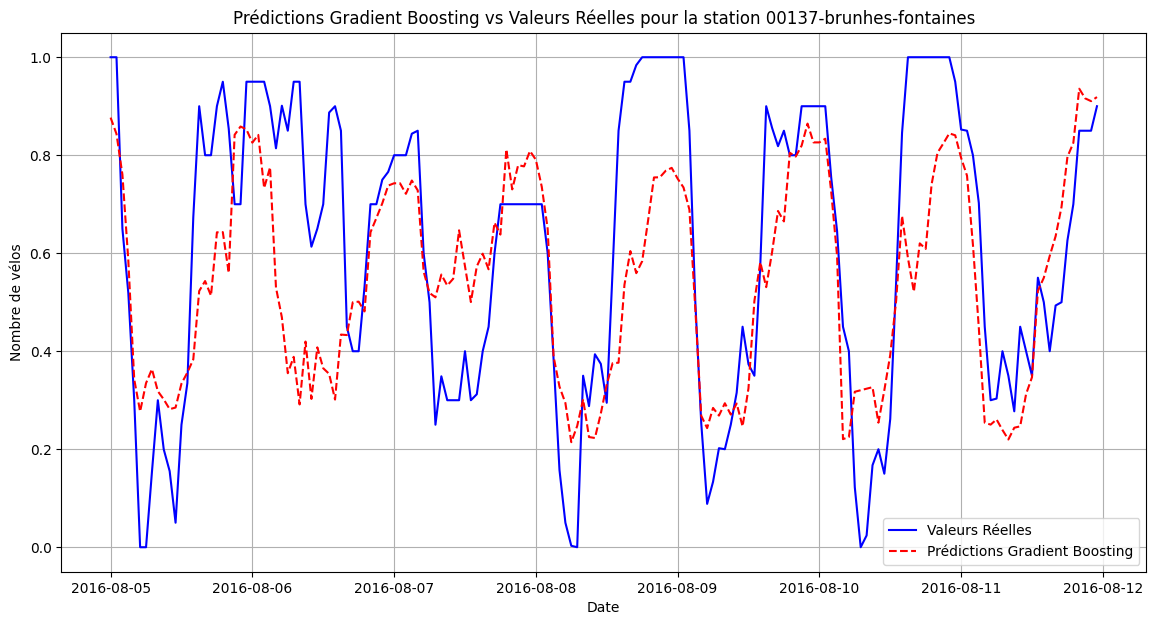

MSE pour les prédictions Gradient Boosting sur la station 00137-brunhes-fontaines: 0.04745573769211379


In [34]:
from sklearn.ensemble import GradientBoostingRegressor

new_station = method.df_dataset.columns[78]  # Changer la station ici
last_train_date = method.train_dataset.index[-1]

start_prediction = last_train_date + pd.DateOffset(hours=1)
end_prediction = start_prediction + pd.DateOffset(hours=PREDICTION_LENGTH - 1)

real_data = method.df_dataset.loc[start_prediction:end_prediction, new_station]

X_train = method.train_dataset.drop(new_station, axis=1)
y_train = method.train_dataset[new_station]
X_test = method.df_dataset.drop(new_station, axis=1).loc[start_prediction:end_prediction]
y_test = method.df_dataset[new_station].loc[start_prediction:end_prediction]

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

plt.figure(figsize=(14, 7))
plt.plot(real_data.index, real_data.values, label='Valeurs Réelles', color='blue')
plt.plot(X_test.index, predictions, label='Prédictions Gradient Boosting', color='red', linestyle='--')
plt.title(f'Prédictions Gradient Boosting vs Valeurs Réelles pour la station {new_station}')
plt.xlabel('Date')
plt.ylabel('Nombre de vélos')
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(y_test.values, predictions)
print(f'MSE pour les prédictions Gradient Boosting sur la station {new_station}: {mse}')
